This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Supported radar data formats

The binary encoding of many radar products is a major obstacle for many potential radar users. Often, decoder software is not easily available. In case formats are documented, the implementation of decoders is a major programming effort. This tutorial provides an overview of the data formats currently supported by $\omega radlib$. We seek to continuously enhance the range of supported formats, so this document is only a snapshot. If you need a specific file format to be supported by $\omega radlib$, please [raise an issue](https://github.com/wradlib/wradlib/issues/new) of type *enhancement*. You can provide support by adding documents which help to decode the format, e.g. format reference documents or software code in other languages for decoding the format.

At the moment, *supported format* means that the radar format can be read and further processed by wradlib. Normally, wradlib will return an array of data values and a dictionary of metadata - if the file contains any. wradlib does not support encoding to any specific file formats, yet! This might change in the future, but it is not a priority. However, you can use Python's netCDF4 or h5py packages to encode the results of your analysis to standard self-describing file formats such as netCDF or hdf5. 

In the following, we will provide an overview of file formats which can be currently read by $\omega radlib$. 

Reading weather radar files is done via the [wradlib.io](https://docs.wradlib.org/en/latest/io.html) module. There you will find a complete function reference. 

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## German Weather Service: DX format

The German Weather Service uses the DX file format to encode local radar sweeps. DX data are in polar coordinates. The naming convention is as follows: <pre>raa00-dx_&lt;location-id&gt;-&lt;YYMMDDHHMM&gt;-&lt;location-abreviation&gt;---bin</pre> or <pre>raa00-dx_&lt;location-id&gt;-&lt;YYYYMMDDHHMM&gt;-&lt;location-abreviation&gt;---bin</pre>
[Read and plot DX radar data from DWD](wradlib_reading_dx.ipynb) provides an extensive introduction into working with DX data. For now, we would just like to know how to read the data:

In [2]:
fpath = 'dx/raa00-dx_10908-0806021655-fbg---bin.gz'
f = wrl.util.get_wradlib_data_file(fpath)
data, metadata = wrl.io.read_dx(f)

Here, ``data`` is a two dimensional array of shape (number of azimuth angles, number of range gates). This means that the number of rows of the array corresponds to the number of azimuth angles of the radar sweep while the number of columns corresponds to the number of range gates per ray.

In [3]:
print(data.shape)
print(metadata.keys())

(360, 128)
dict_keys(['producttype', 'datetime', 'radarid', 'bytes', 'version', 'cluttermap', 'dopplerfilter', 'statfilter', 'elevprofile', 'message', 'elev', 'azim', 'clutter'])


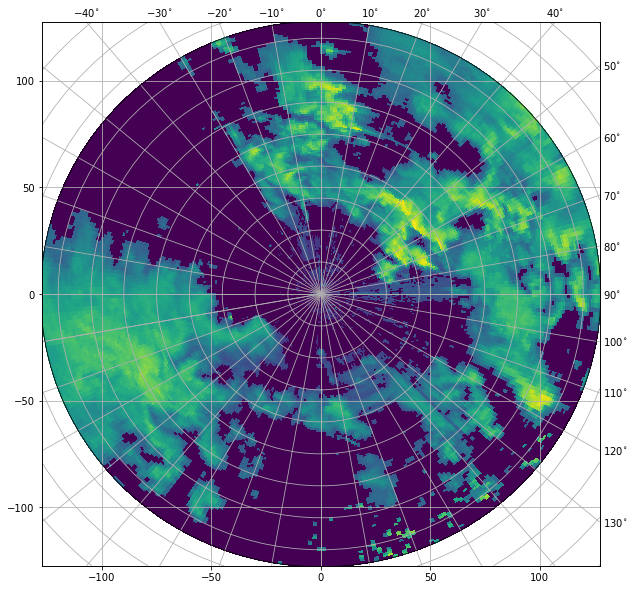

In [4]:
fig = pl.figure(figsize=(10, 10))
ax, im = wrl.vis.plot_ppi(data, fig=fig, proj='cg')

## German Weather Service: RADOLAN (quantitative) composit

The quantitative composite format of the DWD (German Weather Service) was established in the course of the [RADOLAN project](https://www.dwd.de/DE/leistungen/radolan/radolan.html). Most quantitative composite products from the DWD are distributed in this format, e.g. the R-series (RX, RY, RH, RW, ...), the S-series (SQ, SH, SF, ...), and the E-series (European quantitative composite, e.g. EZ, EH, EB). Please see the [composite format description](https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=5) for a full reference and a full table of products (unfortunately only in German language). An extensive section covering many RADOLAN aspects is here: [RADOLAN](../radolan.ipynb)

Currently, the RADOLAN composites have a spatial resolution of 1km x 1km, with the national composits (R- and S-series) being 900 x 900 grids, and the European composits 1500 x 1400 grids. The projection is [polar-stereographic](../radolan/radolan_grid.ipynb#Polar-Stereographic-Projection). The products can be read by the following function:

In [5]:
fpath = 'radolan/misc/raa01-rw_10000-1408102050-dwd---bin.gz'
f = wrl.util.get_wradlib_data_file(fpath)
data, metadata = wrl.io.read_radolan_composite(f)

Here, ``data`` is a two dimensional integer array of shape (number of rows, number of columns). Different product types might need different levels of postprocessing, e.g. if the product contains rain rates or accumulations, you will normally have to divide data by factor 10. ``metadata`` is again a dictionary which provides metadata from the files header section, e.g. using the keys *producttype*, *datetime*, *intervalseconds*, *nodataflag*. 

In [6]:
print(data.shape)
print(metadata.keys())

(900, 900)
dict_keys(['producttype', 'datetime', 'radarid', 'datasize', 'maxrange', 'radolanversion', 'precision', 'intervalseconds', 'nrow', 'ncol', 'radarlocations', 'nodataflag', 'secondary', 'nodatamask', 'cluttermask'])


Masking the NoData (or missing) values can be done by:

In [7]:
maskeddata = np.ma.masked_equal(data, 
                                metadata["nodataflag"])

<Figure size 720x576 with 0 Axes>

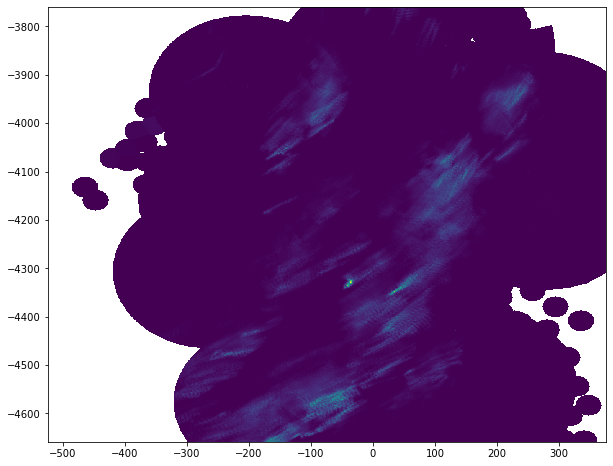

In [8]:
fig = pl.figure(figsize=(10, 8))
# get coordinates
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x = radolan_grid_xy[:, :, 0]
y = radolan_grid_xy[:, :, 1]

# create quick plot with colorbar and title
pl.figure(figsize=(10, 8))
pl.pcolormesh(x, y, maskeddata)

## HDF5

### OPERA HDF5 (ODIM_H5)

[HDF5](https://www.hdfgroup.org/HDF5/) is a data model, library, and file format for storing and managing data. The [OPERA 3 program](http://www.eumetnet.eu/opera) developed a convention (or information model) on how to store and exchange radar data in hdf5 format. It is based on the work of [COST Action 717](https://e-services.cost.eu/files/domain_files/METEO/Action_717/final_report/final_report-717.pdf) and is used e.g. in real-time operations in the Nordic European countries. The OPERA Data and Information Model (ODIM) is documented e.g. in this [report](https://www.eol.ucar.edu/system/files/OPERA_2008_03_WP2.1b_ODIM_H5_v2.1.pdf). Make use of these documents in order to understand the organization of OPERA hdf5 files!

<div class="alert alert-warning">

**Note** <br>

Since $\omega radlib$ version 1.3 an [OdimH5](https://docs.wradlib.org/en/stable/generated/wradlib.io.xarray.OdimH5.html) reader based on [Xarray](http://xarray.pydata.org/en/stable/), [netcdf4](https://unidata.github.io/netcdf4-python/) and [h5py](https://www.h5py.org/) is available. Please read the more indepth notebook [wradlib_xarray_radial_odim](wradlib_xarray_radial_odim.ipynb).

A second implementation based on [netcdf4](https://unidata.github.io/netcdf4-python/), [h5py](https://www.h5py.org/), [h5netcdf](https://github.com/shoyer/h5netcdf) and [Xarray](http://xarray.pydata.org/en/stable/) claiming multiple data files and presenting them in a simple structure is available from $\omega radlib$ version 1.6. See the notebook [wradlib_odim_multi_file_dataset](wradlib_odim_multi_file_dataset.ipynb).

</div>

The hierarchical nature of HDF5 can be described as being similar to directories, files, and links on a hard-drive. Actual metadata are stored as so-called *attributes*, and these attributes are organized together in so-called *groups*. Binary data are stored as so-called *datasets*. As for ODIM_H5, the ``root`` (or top level) group contains three groups of metadata: these are called ``what`` (object, information model version, and date/time information), ``where`` (geographical information), and ``how`` (quality and optional/recommended metadata). For a very simple product, e.g. a CAPPI, the data is organized in a group called ``dataset1`` which contains another group called ``data1`` where the actual binary data are found in ``data``. In analogy with a file system on a hard-disk, the HDF5 file containing this simple product is organized like this:

```
    /
    /what
    /where
    /how
    /dataset1
    /dataset1/data1
    /dataset1/data1/data
```

The philosophy behind the $\omega radlib$ interface to OPERA's data model is very straightforward: $\omega radlib$ simply translates the complete file structure to *one* dictionary and returns this dictionary to the user. Thus, the potential complexity of the stored data is kept and it is left to the user how to proceed with this data. The keys of the output dictionary are strings that correspond to the "directory trees" shown above. Each key ending with ``/data`` points to a Dataset (i.e. a numpy array of data). Each key ending with ``/what``, ``/where`` or ``/how`` points to another dictionary of metadata. The entire output can be obtained by:

In [9]:
fpath = 'hdf5/knmi_polar_volume.h5'
f = wrl.util.get_wradlib_data_file(fpath)
fcontent = wrl.io.read_opera_hdf5(f)

The user should inspect the output obtained from his or her hdf5 file in order to see how access those items which should be further processed. In order to get a readable overview of the output dictionary, one can use the pretty printing module:

In [10]:
# which keyswords can be used to access the content?
print(fcontent.keys())
# print the entire content including values of data and metadata
# (numpy arrays will not be entirely printed)
print(fcontent['dataset1/data1/data'])

dict_keys(['dataset1/data1/data', 'dataset1/data1/what', 'dataset1/what', 'dataset1/where', 'dataset10/data1/data', 'dataset10/data1/what', 'dataset10/what', 'dataset10/where', 'dataset11/data1/data', 'dataset11/data1/what', 'dataset11/what', 'dataset11/where', 'dataset12/data1/data', 'dataset12/data1/what', 'dataset12/what', 'dataset12/where', 'dataset13/data1/data', 'dataset13/data1/what', 'dataset13/what', 'dataset13/where', 'dataset14/data1/data', 'dataset14/data1/what', 'dataset14/what', 'dataset14/where', 'dataset2/data1/data', 'dataset2/data1/what', 'dataset2/what', 'dataset2/where', 'dataset3/data1/data', 'dataset3/data1/what', 'dataset3/what', 'dataset3/where', 'dataset4/data1/data', 'dataset4/data1/what', 'dataset4/what', 'dataset4/where', 'dataset5/data1/data', 'dataset5/data1/what', 'dataset5/what', 'dataset5/where', 'dataset6/data1/data', 'dataset6/data1/what', 'dataset6/what', 'dataset6/where', 'dataset7/data1/data', 'dataset7/data1/what', 'dataset7/what', 'dataset7/where

Please note that in order to experiment with such datasets, you can download hdf5 sample data from the [OPERA](http://eumetnet.eu/activities/observations-programme/current-activities/opera/) or use the example data provided with the [wradlib-data](https://github.com/wradlib/wradlib-data/) repository.

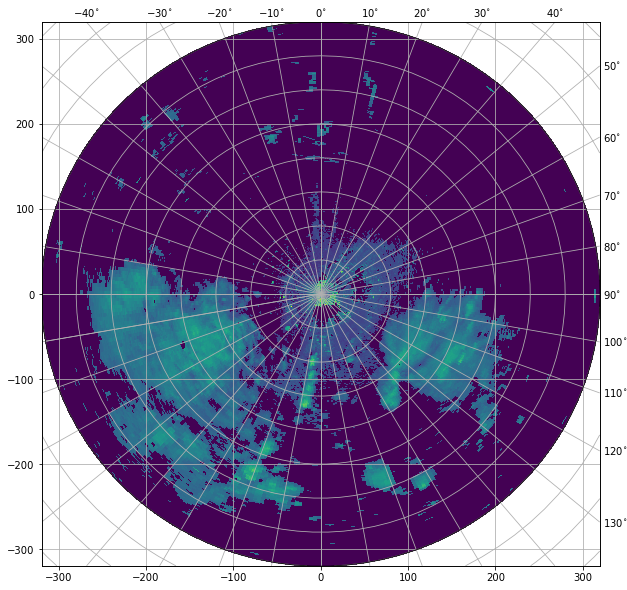

In [11]:
fig = pl.figure(figsize=(10, 10))
im = wrl.vis.plot_ppi(fcontent['dataset1/data1/data'], fig=fig, proj='cg')

### GAMIC HDF5

GAMIC refers to the commercial [GAMIC Enigma MURAN software](https://www.gamic.com) which exports data in hdf5 format. The concept is quite similar to the above [OPERA HDF5 (ODIM_H5)](#OPERA-HDF5-(ODIM_H5)) format. Such a file (typical ending: *.mvol*) can be read by:

In [12]:
fpath = 'hdf5/2014-08-10--182000.ppi.mvol'
f = wrl.util.get_wradlib_data_file(fpath)
data, metadata = wrl.io.read_gamic_hdf5(f)

While metadata represents the usual dictionary of metadata, the data variable is a dictionary which might contain several numpy arrays with the keywords of the dictionary indicating different moments.

In [13]:
print(metadata.keys())
print(metadata['VOL'])
print(metadata['SCAN0'].keys())

dict_keys(['SCAN0', 'VOL'])
{'Latitude': 50.73052, 'Longitude': 7.071663, 'Height': 99.5}
dict_keys(['PRF', 'angle_step', 'angle_sync', 'azi_start', 'azi_stop', 'bin_count', 'elevation', 'filter', 'half_resolution', 'output64', 'pulse_width', 'radar_wave_length', 'range', 'range_samples', 'range_start', 'range_step', 'ray_count', 'scan_speed', 'time_samples', 'unfolding', 'bin_range', 'zero_index', 'az', 'el', 'r', 'Time', 'max_range'])


In [14]:
print(data['SCAN0'].keys())
print(data['SCAN0']['PHIDP'].keys())
print(data['SCAN0']['PHIDP']['data'].shape)

dict_keys(['KDP', 'PHIDP', 'ZH', 'ZV', 'RHOHV', 'UH', 'UV', 'VH', 'VV', 'WH', 'WV', 'ZDR'])
dict_keys(['data', 'dyn_range_max', 'dyn_range_min'])
(360, 1000)


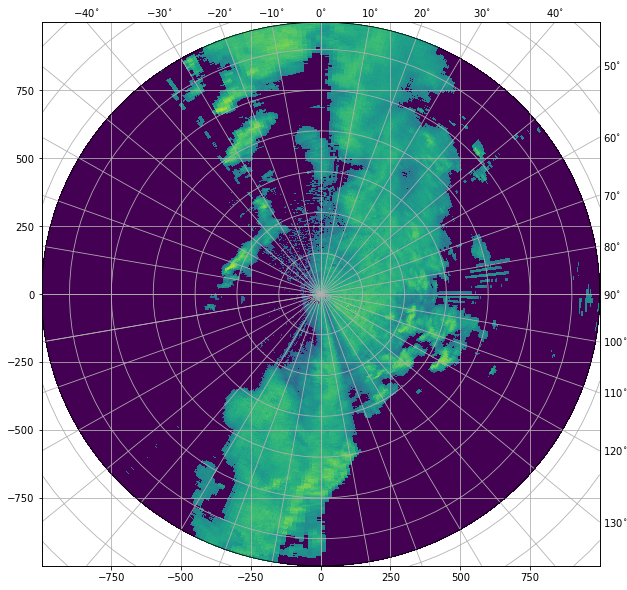

In [15]:
fig = pl.figure(figsize=(10, 10))
im = wrl.vis.plot_ppi(data['SCAN0']['ZH']['data'], fig=fig, proj='cg')

### Generic HDF5

This is a generic hdf5 reader, which will read any hdf5 structure.

In [16]:
fpath = 'hdf5/2014-08-10--182000.ppi.mvol'
f = wrl.util.get_wradlib_data_file(fpath)
fcontent = wrl.io.read_generic_hdf5(f)

In [17]:
print(fcontent.keys())

dict_keys(['how', 'scan0/how', 'scan0/how/extended', 'scan0/moment_0', 'scan0/moment_1', 'scan0/moment_10', 'scan0/moment_11', 'scan0/moment_2', 'scan0/moment_3', 'scan0/moment_4', 'scan0/moment_5', 'scan0/moment_6', 'scan0/moment_7', 'scan0/moment_8', 'scan0/moment_9', 'scan0/ray_header', 'scan0/what', 'what', 'where'])


In [18]:
print(fcontent['where'])
print(fcontent['how'])
print(fcontent['scan0/moment_3'].keys())
print(fcontent['scan0/moment_3']['attrs'])
print(fcontent['scan0/moment_3']['data'].shape)


{'attrs': {'height': 99.5, 'lat': 50.73052, 'lon': 7.071663}}
{'attrs': {'azimuth_beam': 1.0, 'elevation_beam': 1.0, 'host_name': 'radar.meteo.uni-bonn.de', 'sdp_name': 'ENIGMA III DUALPOL', 'site_name': '12345', 'software': 'MURAN', 'template_name': 'ppi_1p5deg'}}
dict_keys(['attrs', 'data'])
{'dyn_range_max': 95.5, 'dyn_range_min': -32.0, 'format': 'UV8', 'moment': 'UH'}
(360, 1000)


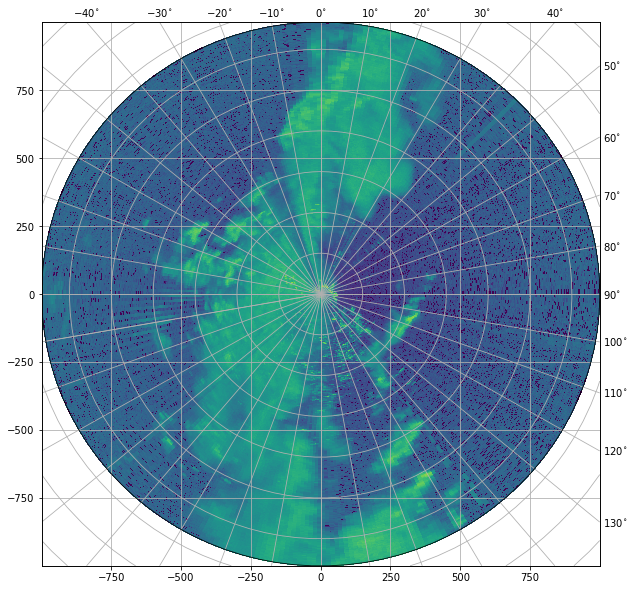

In [19]:
fig = pl.figure(figsize=(10, 10))
im = wrl.vis.plot_ppi(fcontent['scan0/moment_3']['data'], fig=fig, proj='cg')

## NetCDF

The NetCDF format also claims to be self-describing. However, as for all such formats, the developers of netCDF also admit that "[...] the mere use of netCDF is not sufficient to make data self-describing and meaningful to both humans and machines [...]" (see [here](https://www.unidata.ucar.edu/software/netcdf/documentation/historic/netcdf/Conventions.html). Different radar operators or data distributors will use different naming conventions and data hierarchies (i.e. "data models") that the reading program might need to know about.

$\omega radlib$ provides two solutions to address this challenge. The first one ignores the concept of data models and just pulls all data and metadata from a NetCDF file ([wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html). The second is designed for a specific data model used by the EDGE software ([wradlib.io.read_edge_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_edge_netcdf.html)).

<div class="alert alert-warning">

**Note** <br>

Since $\omega radlib$ version 1.3 an [Cf/Radial](https://docs.wradlib.org/en/stable/generated/wradlib.io.xarray.CfRadial.html) reader for CF versions 1.X and 2 based on [Xarray](http://xarray.pydata.org/en/stable/) and [netcdf4](https://unidata.github.io/netcdf4-python/) is available. Please read the more indepth notebook [wradlib_xarray_radial_odim](wradlib_xarray_radial_odim.ipynb).

</div>

### Generic NetCDF reader (includes CfRadial)

$\omega radlib$ provides a function that will virtually read any NetCDF file irrespective of the data model: [wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html). It is built upon Python's [netcdf4](https://unidata.github.io/netcdf4-python/) library. [wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html) will return only one object, a dictionary, that contains all the contents of the NetCDF file corresponding to the original file structure. This includes all the metadata, as well as the so called "dimensions" (describing the dimensions of the actual data arrays) and the "variables" which will contains the actual data. Users can use this dictionary at will in order to query data and metadata; however, they should make sure to consider the documentation of the corresponding data model. [wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html) has been shown to work with a lot of different data models, most notably **CfRadial** (see [here](https://www.ral.ucar.edu/projects/titan/docs/radial_formats/cfradial.html) for details). A typical call to [wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html) would look like:

In [20]:
fpath = 'netcdf/example_cfradial_ppi.nc'
f = wrl.util.get_wradlib_data_file(fpath)
outdict = wrl.io.read_generic_netcdf(f)
for key in outdict.keys():
    print(key)

comment
title
Conventions
source
version
references
instrument_name
institution
field_names
history
dimensions
variables


Please see [this example notebook](wradlib_generic_netcdf_example.ipynb) to get started.

### EDGE NetCDF

EDGE is a commercial software for radar control and data analysis provided by the Enterprise Electronics Corporation. It allows for netCDF data export. The resulting files can be read by [wradlib.io.read_generic_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_generic_netcdf.html), but $\omega radlib$ also provides a specific function,  [wradlib.io.read_edge_netcdf()](https://docs.wradlib.org/en/latest/generated/wradlib.io.netcdf.read_edge_netcdf.html) to return metadata and data as seperate objects:

In [21]:
fpath = 'netcdf/edge_netcdf.nc'
f = wrl.util.get_wradlib_data_file(fpath) 
data, metadata = wrl.io.read_edge_netcdf(f)
print(data.shape)
print(metadata.keys())

(360, 240)
dict_keys(['TypeName', 'DataType', 'Latitude', 'Longitude', 'Height', 'FractionalTime', 'attributes', 'NyquistVelocity-unit', 'NyquistVelocity-value', 'vcp-unit', 'vcp-value', 'radarName-unit', 'radarName-value', 'ColorMap-unit', 'ColorMap-value', 'Elevation', 'ElevationUnits', 'MissingData', 'RangeFolded', 'RadarParameters', 'PRF-unit', 'PRF-value', 'PulseWidth-unit', 'PulseWidth-value', 'MaximumRange-unit', 'MaximumRange-value', 'ConversionPlugin', 'az', 'r', 'sitecoords', 'time', 'max_range'])


## Gematronik Rainbow

Rainbow refers to the commercial [RAINBOW®5 APPLICATION SOFTWARE](http://www.de.selex-es.com/capabilities/meteorology/products/components/rainbow5) which exports data in an XML flavour, which due to binary data blobs violates XML standard. Gematronik provided python code for implementing this reader in $\omega radlib$, which is very much appreciated.

The philosophy behind the $\omega radlib$ interface to Gematroniks data model is very straightforward: $\omega radlib$ simply translates the complete xml file structure to *one* dictionary and returns this dictionary to the user. Thus, the potential complexity of the stored data is kept and it is left to the user how to proceed with this data. The keys of the output dictionary are strings that correspond to the "xml nodes" and "xml attributes". Each ``data`` key points to a Dataset (i.e. a numpy array of data). Such a file (typical ending: *.vol* or *.azi*) can be read by:

In [22]:
fpath = 'rainbow/2013070308340000dBuZ.azi'
f = wrl.util.get_wradlib_data_file(fpath)
fcontent = wrl.io.read_rainbow(f)

The user should inspect the output obtained from his or her Rainbow file in order to see how access those items which should be further processed. In order to get a readable overview of the output dictionary, one can use the pretty printing module:

In [23]:
# which keyswords can be used to access the content?
print(fcontent.keys())
# print the entire content including values of data and metadata
# (numpy arrays will not be entirely printed)
print(fcontent['volume']['sensorinfo'])

odict_keys(['volume'])
OrderedDict([('@type', 'rainscanner'), ('@id', 'WUE'), ('@name', 'Wuestebach'), ('lon', '6.330970'), ('lat', '50.504900'), ('alt', '0.000000'), ('wavelen', '0.05'), ('beamwidth', '1')])


You can check this [example notebook](wradlib_load_rainbow_example.ipynb) for getting a first impression.

## Vaisala Sigmet IRIS 

[IRIS](https://www.vaisala.com/en/products/instruments-sensors-and-other-measurement-devices/weather-radar-products/iris-focus) refers to the commercial Vaisala Sigmet **I**nteractive **R**adar **I**nformation **S**ystem. The Vaisala Sigmet Digital Receivers export data in a [well documented](ftp://ftp.sigmet.com/outgoing/manuals/IRIS_Programmers_Manual.pdf) binary format.

The philosophy behind the $\omega radlib$ interface to the IRIS data model is very straightforward: $\omega radlib$ simply translates the complete binary file structure to *one* dictionary and returns this dictionary to the user. Thus, the potential complexity of the stored data is kept and it is left to the user how to proceed with this data. The keys of the output dictionary are strings that correspond to the Sigmet Data Structures. 

Each ``data`` key points to a Dataset (i.e. a numpy array of data). Such a file (typical ending: *.RAWXXXX) can be read by:

In [24]:
fpath = 'sigmet/cor-main131125105503.RAW2049'
f = wrl.util.get_wradlib_data_file(fpath)
fcontent = wrl.io.read_iris(f)

In [25]:
# which keywords can be used to access the content?
print(fcontent.keys())
# print the entire content including values of data and 
# metadata of the first sweep
# (numpy arrays will not be entirely printed)
print(fcontent['data'][1].keys())
print()
print(fcontent['data'][1]['ingest_data_hdrs'].keys())
print(fcontent['data'][1]['ingest_data_hdrs']['DB_DBZ'])
print()
print(fcontent['data'][1]['sweep_data'].keys())
print(fcontent['data'][1]['sweep_data']['DB_DBZ'])

odict_keys(['product_hdr', 'product_type', 'ingest_header', 'nsweeps', 'nrays', 'nbins', 'data_types', 'data', 'raw_product_bhdrs'])
odict_keys(['ingest_data_hdrs', 'sweep_data'])

odict_keys(['DB_DBZ', 'DB_VEL', 'DB_ZDR', 'DB_KDP', 'DB_PHIDP', 'DB_RHOHV', 'DB_HCLASS'])
OrderedDict([('structure_header', OrderedDict([('structure_identifier', 24), ('format_version', 3), ('bytes_in_structure', 244876), ('flag', 1)])), ('sweep_start_time', datetime.datetime(2013, 11, 25, 10, 55, 5, 589000)), ('sweep_number', 1), ('number_rays_per_sweep', 360), ('first_ray_index', 0), ('number_rays_file_expected', 360), ('number_rays_file_written', 360), ('fixed_angle', 0.4998779296875), ('bits_per_bin', 8), ('data_type', 2)])

odict_keys(['DB_DBZ', 'DB_VEL', 'DB_ZDR', 'DB_KDP', 'DB_PHIDP', 'DB_RHOHV', 'DB_HCLASS'])
OrderedDict([('data', array([[-32. ,   3.5,   6. , ..., -32. , -32. , -32. ],
       [-20.5, -32. , -32. , ..., -32. , -32. , -32. ],
       [-32. , -32. , -32. , ..., -32. , -32. , -32. ],
    

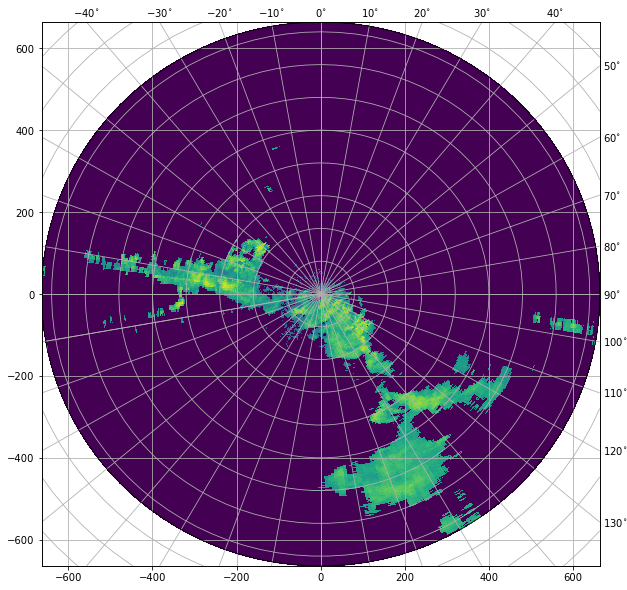

In [26]:
fig = pl.figure(figsize=(10, 10))
swp = fcontent['data'][1]['sweep_data']
ax, im = wrl.vis.plot_ppi(swp["DB_DBZ"]['data'], fig=fig, proj='cg')

## OPERA BUFR

**WARNING** $\omega radlib$ does currently not support the BUFR format!

The Binary Universal Form for the Representation of meteorological data (BUFR) is a binary data format maintained by the World Meteorological Organization (WMO).

The BUFR format was adopted by [OPERA](http://eumetnet.eu/activities/observations-programme/current-activities/opera/) for the representation of weather radar data.
A BUFR file consists of a set of *descriptors* which contain all the relevant metadata and a data section. 
The *descriptors* are identified as a tuple of three integers. The meaning of these tupels is described in the so-called BUFR tables. There are generic BUFR tables provided by the WMO, but it is also possible to define so called *local tables* - which was done by the OPERA consortium for the purpose of radar data representation.
 
If you want to use BUFR files together with $\omega radlib$, we recommend that you check out the [OPERA webpage](http://eumetnet.eu/activities/observations-programme/current-activities/opera/) where you will find software for BUFR decoding. In particular, you might want to check out [this tool](http://eumetnet.eu/wp-content/uploads/2017/04/bufr_opera_mf.zip) which seems to support the conversion of OPERA BUFR files to ODIM_H5 (which is supported by $\omega radlib$). However, you have to build it yourself.

It would be great if someone could add a tutorial on how to use OPERA BUFR software together with $\omega radlib$!